# Interactive FlowMRI Viewer

In [1]:
# Notebook parameters - to be moved into papermill parameters
import os
hpc_predict_data_root = "/hpc-predict-data"
# hpc_predict_data_root = os.path.join(os.environ['HOME'], "src/hpc-predict/hpc-predict/data/v1")
mri_file_name = os.environ['HPC_PREDICT_MRI_PATH']
print(f"Processing {mri_file_name}.")

Processing decrypt/input_data/preprocessed/mri/MRT Daten Bern tar/2021-05-14_22-40-32_ThinkPad-X1/11/11-100028CE-100028CF.h5.


In [2]:
import sys
import tarfile
import json
import pydicom
import pandas as pd
import numpy as np
from pprint import pprint
from mr_io import FlowMRI

mri_file_path = os.path.join(hpc_predict_data_root, mri_file_name)
if not os.path.exists(mri_file_path):
    raise RuntimeError(f"MRI file not found at {mri_file_path}: file does not exist.")
hpc_predict_mri = FlowMRI.read_hdf5(mri_file_path)

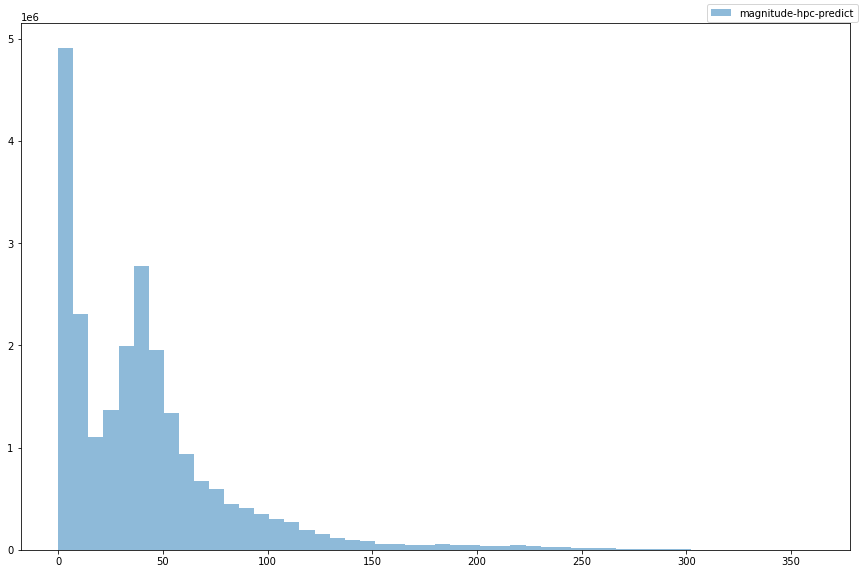

In [3]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(ncols=1, figsize=(12*1,8*1))
ax.hist(hpc_predict_mri.intensity.flatten(), bins=50, label='magnitude-hpc-predict', alpha=0.5)
figure.legend()
figure.tight_layout()

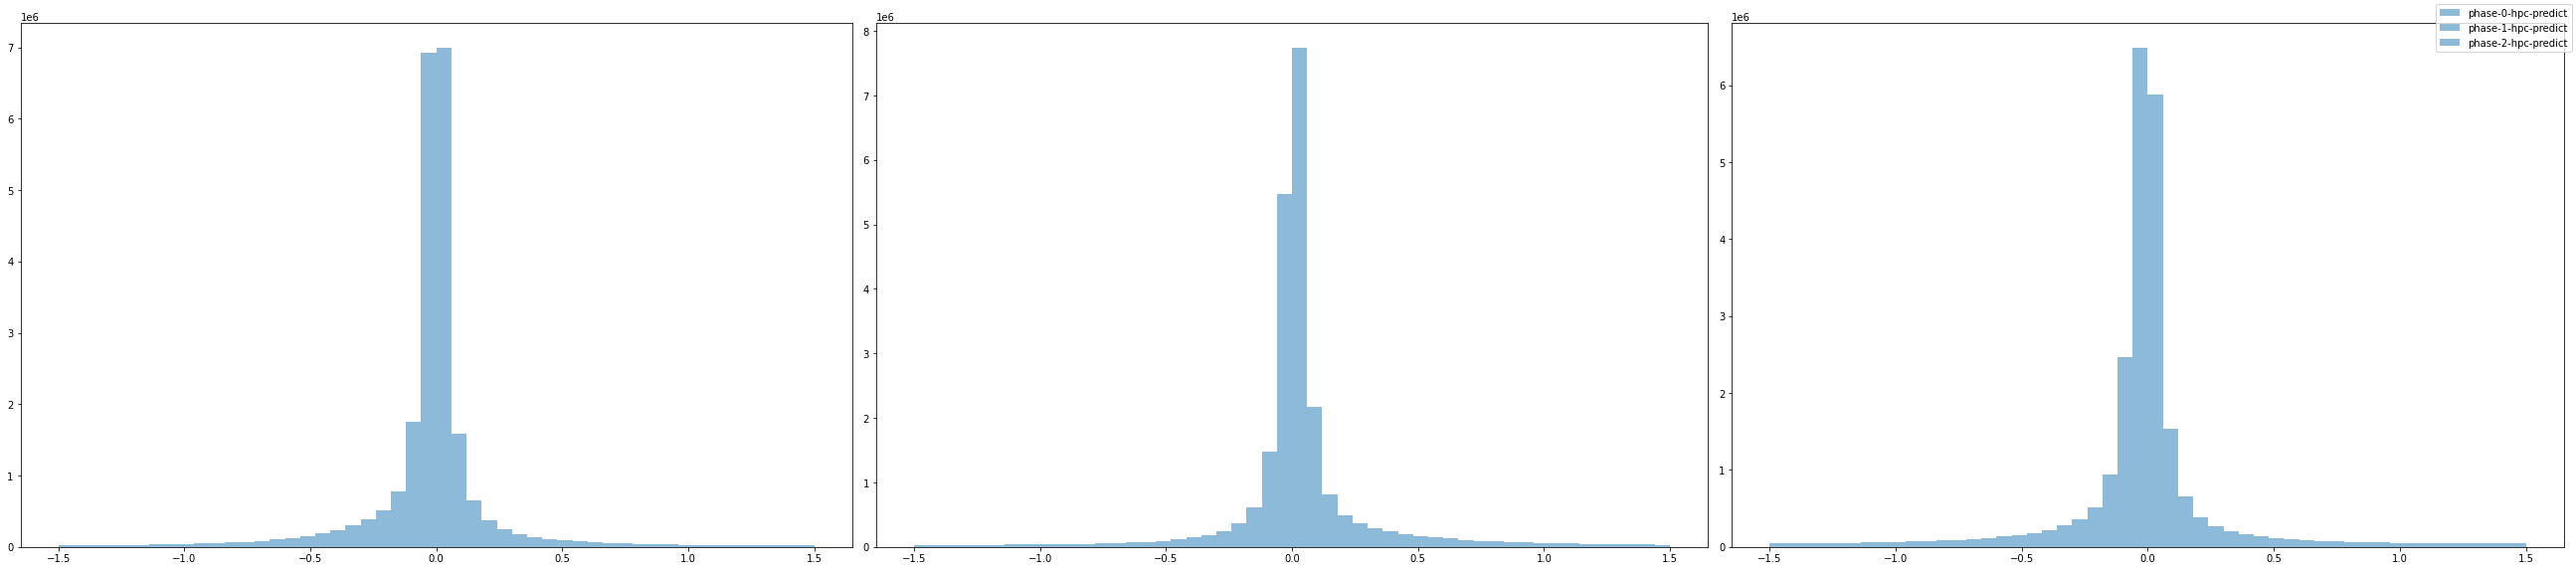

In [4]:
figure, ax = plt.subplots(ncols=3, sharex=True, figsize=(12*3,8*1))
for j in range(3):
    ax[j].hist(hpc_predict_mri.velocity_mean[:,:,:,:,j].flatten(), bins=50, label='phase-{}-hpc-predict'.format(j), alpha=0.5)
figure.legend()
figure.tight_layout()

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def flow_intensity_animation(z, t):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(44,10), sharey=True, sharex=True)
    ax[0].quiver( hpc_predict_mri.velocity_mean[:,:,z, t, 0], 
                  hpc_predict_mri.velocity_mean[:,:,z, t, 1], 
                  hpc_predict_mri.velocity_mean[:,:,z, t, 2])
    ax[1].imshow(hpc_predict_mri.intensity[:,:,z, t], cmap='gray')
    ax[2].imshow(hpc_predict_mri.velocity_mean[:,:,z, t, 0], cmap='gray')
    ax[3].imshow(hpc_predict_mri.velocity_mean[:,:,z, t, 1], cmap='gray')
    ax[4].imshow(hpc_predict_mri.velocity_mean[:,:,z, t, 2], cmap='gray')
    return z, t

interact(flow_intensity_animation, z=(0, hpc_predict_mri.intensity.shape[2]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=14, description='z', max=29), IntSlider(value=19, description='t', max=3…

<function __main__.flow_intensity_animation(z, t)>

In [6]:
# x_min = 40
# x_max = -1
# y_min = 30
# y_max = -30

# def flow_intensity_combined_animation(z, t):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(88,20), sharey=True, sharex=True)
#     ax.imshow(hpc_predict_mri.intensity[x_min:x_max,y_min:y_max,z, t], alpha=0.7, cmap='gray')
#     ax.quiver(hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 1], 
#               hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 0], 
#                np.linalg.norm(hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, :], axis=2))
#     return z, t

# interact(flow_intensity_combined_animation, z=(0, hpc_predict_mri.intensity.shape[2]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

## Magnitude and phase combined

### Sagittal | Coronary | Axial (all vertical)

In [7]:
# Vertical view 

# Region of interest
x_min = 0
x_max = len(hpc_predict_mri.geometry[0])
y_min = 0
y_max = len(hpc_predict_mri.geometry[1])-0
z_min = 0
z_max = len(hpc_predict_mri.geometry[2])

def flow_intensity_combined_xyz_animation(x, y, z, t):
    fig, old_ax = plt.subplots(nrows=3, ncols=3, figsize=(26,20), 
                           gridspec_kw=dict(width_ratios=[  hpc_predict_mri.geometry[1][y_max-1]-hpc_predict_mri.geometry[1][y_min],     hpc_predict_mri.geometry[2][z_max-1]-hpc_predict_mri.geometry[2][z_min], hpc_predict_mri.geometry[2][z_max-1]-hpc_predict_mri.geometry[2][z_min] ], 
                                            height_ratios=[((hpc_predict_mri.geometry[0][x_max-1]-hpc_predict_mri.geometry[0][x_min]) - (hpc_predict_mri.geometry[1][y_max-1]-hpc_predict_mri.geometry[1][y_min]))/2., 
                                                             hpc_predict_mri.geometry[1][y_max-1]-hpc_predict_mri.geometry[1][y_min],
                                                           ((hpc_predict_mri.geometry[0][x_max-1]-hpc_predict_mri.geometry[0][x_min]) - (hpc_predict_mri.geometry[1][y_max-1]-hpc_predict_mri.geometry[1][y_min]))/2.]), 
                           sharey=True)
    gs = (old_ax[0,0].get_gridspec(), old_ax[0,1].get_gridspec()) 
    for ax in list(old_ax[:,0]) + list(old_ax[:,1]) + list(old_ax[::2,2]):
        ax.remove()
    ax = [fig.add_subplot(gs[0][:,0]), fig.add_subplot(gs[1][:,1]), old_ax[1,2]]
    
    ax[0].pcolormesh(hpc_predict_mri.geometry[1][y_min:y_max],
                  -hpc_predict_mri.geometry[0][x_min:x_max], # x-axis reversal for easier viewing
                  hpc_predict_mri.intensity[x_min:x_max,y_min:y_max,z, t], # because ordering is expected as (second axis, first axis)
                  shading='auto', cmap='gray')
    ax[0].quiver(hpc_predict_mri.geometry[1][y_min:y_max],
              -hpc_predict_mri.geometry[0][x_min:x_max], # x-axis reversal for easier viewing
              hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 1], # velocity sign can be reverted here to correct for unphysiological flows
              -hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 0], # x-axis reversal for easier viewing
              np.linalg.norm(hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, :], axis=2) )
    ax[0].plot([hpc_predict_mri.geometry[1][y],     hpc_predict_mri.geometry[1][y]],      [-hpc_predict_mri.geometry[0][x_min],-hpc_predict_mri.geometry[0][x_max-1]], color='cyan', alpha=0.3)
    ax[0].plot([hpc_predict_mri.geometry[1][y_min], hpc_predict_mri.geometry[1][y_max-1]],[-hpc_predict_mri.geometry[0][x],    -hpc_predict_mri.geometry[0][x]],       color='orange', alpha=0.3)
    ax[0].set_title("Sagittal View (z fixed)", color='magenta')
    ax[0].set_xlabel("anterior -> posterior (MRI-y-axis), velocity inverted!")
    ax[0].set_ylabel("inferior -> superior (neg. MRI-x-axis)")
    
    ax[1].pcolormesh(hpc_predict_mri.geometry[2][z_min:z_max],
                  -hpc_predict_mri.geometry[0][x_min:x_max],
                  hpc_predict_mri.intensity[x_min:x_max,y,z_min:z_max, t], 
                  shading='auto', cmap='gray')
    ax[1].quiver(hpc_predict_mri.geometry[2][z_min:z_max],
              -hpc_predict_mri.geometry[0][x_min:x_max],
              hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, 2], 
              -hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, 0], 
              np.linalg.norm(hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, :], axis=2) )
    ax[1].plot([hpc_predict_mri.geometry[2][z],     hpc_predict_mri.geometry[2][z]],      [-hpc_predict_mri.geometry[0][x_min],-hpc_predict_mri.geometry[0][x_max-1]], color='magenta', alpha=0.3)
    ax[1].plot([hpc_predict_mri.geometry[2][z_min], hpc_predict_mri.geometry[2][z_max-1]],[-hpc_predict_mri.geometry[0][x],    -hpc_predict_mri.geometry[0][x]],       color='orange', alpha=0.3)
    ax[1].set_title("Coronary View  (y fixed)", color='cyan')
    ax[1].set_xlabel("right (medial) -> left (lateral) (MRI-z-axis)")
    ax[1].set_ylabel("inferior -> superior (neg. MRI-x-axis)")
    
    ax[2].pcolormesh(hpc_predict_mri.geometry[2][z_min:z_max],
                  -hpc_predict_mri.geometry[1][y_min:y_max],
                  hpc_predict_mri.intensity[x,y_min:y_max,z_min:z_max, t], 
                  shading='auto', cmap='gray')
    ax[2].quiver(hpc_predict_mri.geometry[2][z_min:z_max],
              -hpc_predict_mri.geometry[1][y_min:y_max],
              hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, 2], 
              -hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, 1], 
              np.linalg.norm(hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, :], axis=2) )
    ax[2].plot([hpc_predict_mri.geometry[2][z],     hpc_predict_mri.geometry[2][z]],      [-hpc_predict_mri.geometry[1][y_min],-hpc_predict_mri.geometry[1][y_max-1]], color='magenta', alpha=0.3)
    ax[2].plot([hpc_predict_mri.geometry[2][z_min], hpc_predict_mri.geometry[2][z_max-1]],[-hpc_predict_mri.geometry[1][y],    -hpc_predict_mri.geometry[1][y]],       color='cyan', alpha=0.3)
    ax[2].set_title("Axial View (x fixed)", color='orange')
    ax[2].set_xlabel("right (medial) -> left (lateral) (MRI-z-axis)")
    ax[2].set_ylabel("posterior -> anterior (MRI-y-axis), velocity inverted!")    
    
    return x, y, z, t

interact(flow_intensity_combined_xyz_animation, x=(0, hpc_predict_mri.intensity.shape[0]-1), y=(0, hpc_predict_mri.intensity.shape[1]-1), z=(0, hpc_predict_mri.intensity.shape[2]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=79, description='x', max=159), IntSlider(value=59, description='y', max=…

<function __main__.flow_intensity_combined_xyz_animation(x, y, z, t)>

### Sagittal view, vertical (watch out for MRI-y-velocity inverted!)

In [8]:
# Vertical view (alternative, less wide-screen friendly)

# Region of interest
x_min = 0
x_max = len(hpc_predict_mri.geometry[0])
y_min = 0
y_max = len(hpc_predict_mri.geometry[1])-0

def flow_intensity_combined_xy_animation(z, t):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,20))
    ax.pcolormesh(hpc_predict_mri.geometry[1][y_min:y_max],
                  -hpc_predict_mri.geometry[0][x_min:x_max], # x-axis reversal for easier viewing
                  hpc_predict_mri.intensity[x_min:x_max,y_min:y_max,z, t], # because ordering is expected as (second axis, first axis)
                  shading='auto', cmap='gray')
    ax.quiver(hpc_predict_mri.geometry[1][y_min:y_max],
              -hpc_predict_mri.geometry[0][x_min:x_max], # x-axis reversal for easier viewing
              hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 1], # velocity sign can be reverted here to correct for unphysiological flows
              -hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 0], # x-axis reversal for easier viewing
              np.linalg.norm(hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, :], axis=2) )
    ax.set_title("Sagittal View")
    ax.set_xlabel("anterior -> posterior (MRI-y-axis), velocity inverted!")
    ax.set_ylabel("inferior -> superior (neg. MRI-x-axis)")

    return z, t

interact(flow_intensity_combined_xy_animation, z=(0, hpc_predict_mri.intensity.shape[2]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=14, description='z', max=29), IntSlider(value=19, description='t', max=3…

<function __main__.flow_intensity_combined_xy_animation(z, t)>

### Coronary view, vertical

In [9]:
# Vertical view (alternative, less wide-screen friendly)

# Region of interest
x_min = 0
x_max = len(hpc_predict_mri.geometry[0])
z_min = 0
z_max = len(hpc_predict_mri.geometry[2])

def flow_intensity_combined_xz_animation(y, t):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8.5,25))
    ax.pcolormesh(hpc_predict_mri.geometry[2][z_min:z_max],
                  -hpc_predict_mri.geometry[0][x_min:x_max],
                  hpc_predict_mri.intensity[x_min:x_max,y,z_min:z_max, t], 
                  shading='auto', cmap='gray')
    ax.quiver(hpc_predict_mri.geometry[2][z_min:z_max],
              -hpc_predict_mri.geometry[0][x_min:x_max],
              hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, 2], 
              -hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, 0], 
              np.linalg.norm(hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, :], axis=2) )
    ax.set_title("Coronary View")
    ax.set_xlabel("right (medial) -> left (lateral) (MRI-z-axis)")
    ax.set_ylabel("inferior -> superior (neg. MRI-x-axis)")
    
    return y, t

interact(flow_intensity_combined_xz_animation, y=(0, hpc_predict_mri.intensity.shape[1]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=59, description='y', max=119), IntSlider(value=19, description='t', max=…

<function __main__.flow_intensity_combined_xz_animation(y, t)>

### Axial view, vertical

In [10]:
# Vertical view (alternative, less wide-screen friendly)

# Region of interest
y_min = 0
y_max = len(hpc_predict_mri.geometry[0])
z_min = 0
z_max = len(hpc_predict_mri.geometry[2])

def flow_intensity_combined_yz_animation(x, t):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8.5,25))
    ax.pcolormesh(hpc_predict_mri.geometry[2][z_min:z_max],
                  -hpc_predict_mri.geometry[1][y_min:y_max],
                  hpc_predict_mri.intensity[x,y_min:y_max,z_min:z_max, t], 
                  shading='auto', cmap='gray')
    ax.quiver(hpc_predict_mri.geometry[2][z_min:z_max],
              -hpc_predict_mri.geometry[1][y_min:y_max],
              hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, 2], 
              -hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, 1], 
              np.linalg.norm(hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, :], axis=2) )
    ax.set_title("Axial View")
    ax.set_xlabel("right (medial) -> left (lateral) (MRI-z-axis)")
    ax.set_ylabel("posterior -> anterior (MRI-y-axis), velocity inverted!")
    
    return x, t

interact(flow_intensity_combined_yz_animation, x=(0, hpc_predict_mri.intensity.shape[1]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=59, description='x', max=119), IntSlider(value=19, description='t', max=…

<function __main__.flow_intensity_combined_yz_animation(x, t)>

### Sagittal view, horizontal (watch out for MRI-y-velocity inverted!)

In [11]:
# Horizontal view

# Region of interest
x_min = 0
x_max = len(hpc_predict_mri.geometry[0])
y_min = 0
y_max = len(hpc_predict_mri.geometry[1])-0

def flow_intensity_combined_xy_animation(z, t):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,15))
    ax.pcolormesh(hpc_predict_mri.geometry[0][x_min:x_max],
                  hpc_predict_mri.geometry[1][y_min:y_max],
                  hpc_predict_mri.intensity[x_min:x_max,y_min:y_max,z, t].transpose(), # because ordering is expected as (second axis, first axis)
                  shading='auto', cmap='gray')
    ax.quiver(hpc_predict_mri.geometry[0][x_min:x_max],
              hpc_predict_mri.geometry[1][y_min:y_max],
              hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 0].transpose(), # order because first-axis component comes first 
              hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, 1].transpose(), # velocity sign can be reverted here to correct for unphysiological flows
              np.linalg.norm(hpc_predict_mri.velocity_mean[x_min:x_max,y_min:y_max,z, t, :].transpose([1,0,2]), axis=2) )
    ax.set_title("Sagittal View")
    ax.set_xlabel("superior -> inferior (MRI-x-axis)")
    ax.set_ylabel("anterior -> posterior (MRI-y-axis), velocity inverted!")
    
    return z, t

interact(flow_intensity_combined_xy_animation, z=(0, hpc_predict_mri.intensity.shape[2]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=14, description='z', max=29), IntSlider(value=19, description='t', max=3…

<function __main__.flow_intensity_combined_xy_animation(z, t)>

### Coronary view, horizontal

In [12]:
# Horizontal view

# Region of interest
x_min = 0
x_max = len(hpc_predict_mri.geometry[0])
z_min = 0
z_max = len(hpc_predict_mri.geometry[2])

def flow_intensity_combined_xz_animation(y, t):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7.5))
    ax.pcolormesh(hpc_predict_mri.geometry[0][x_min:x_max],
                  hpc_predict_mri.geometry[2][z_min:z_max],
                  hpc_predict_mri.intensity[x_min:x_max,y,z_min:z_max, t].transpose(), 
                  shading='auto', cmap='gray')
    ax.quiver(hpc_predict_mri.geometry[0][x_min:x_max],
              hpc_predict_mri.geometry[2][z_min:z_max],
              hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, 0].transpose(), 
              hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, 2].transpose(), 
              np.linalg.norm(hpc_predict_mri.velocity_mean[x_min:x_max,y,z_min:z_max, t, :].transpose([1,0,2]), axis=2) )
    ax.set_title("Coronary View")
    ax.set_xlabel("superior -> inferior (MRI-x-axis)")
    ax.set_ylabel("right (medial) -> left (lateral) (MRI-z-axis)")
    
    return y, t

interact(flow_intensity_combined_xz_animation, y=(0, hpc_predict_mri.intensity.shape[1]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=59, description='y', max=119), IntSlider(value=19, description='t', max=…

<function __main__.flow_intensity_combined_xz_animation(y, t)>

### Axial view, horizontal

In [13]:
# Horizontal view

# Region of interest
y_min = 0
y_max = len(hpc_predict_mri.geometry[1])
z_min = 0
z_max = len(hpc_predict_mri.geometry[2])

def flow_intensity_combined_yz_animation(x, t):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7.5))
    ax.pcolormesh(hpc_predict_mri.geometry[1][y_min:y_max],
                  hpc_predict_mri.geometry[2][z_min:z_max],
                  hpc_predict_mri.intensity[x,y_min:y_max,z_min:z_max, t].transpose(), 
                  shading='auto', cmap='gray')
    ax.quiver(hpc_predict_mri.geometry[1][y_min:y_max],
              hpc_predict_mri.geometry[2][z_min:z_max],
              hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, 1].transpose(), 
              hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, 2].transpose(), 
              np.linalg.norm(hpc_predict_mri.velocity_mean[x,y_min:y_max,z_min:z_max, t, :].transpose([1,0,2]), axis=2) )
    ax.set_title("Axial View")
    ax.set_xlabel("anterior -> posterior (MRI-y-axis), velocity inverted!")
    ax.set_ylabel("right (medial) -> left (lateral) (MRI-z-axis)")
    
    return x, t

interact(flow_intensity_combined_yz_animation, x=(0, hpc_predict_mri.intensity.shape[0]-1), t=(0, hpc_predict_mri.intensity.shape[3]-1))

interactive(children=(IntSlider(value=79, description='x', max=159), IntSlider(value=19, description='t', max=…

<function __main__.flow_intensity_combined_yz_animation(x, t)>